# Time Series Analysis Notes

My notes on DataCamp's [Time Series Analysis in Python](https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/) course (1-5), notes on [Machine Learning Mastery](machinelearningmastery.com) tutorials (6-8), and my notes on Alina Zhang's [exponential smoothing, Holt, and Holt-Winters](https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1) Python models tutorial, with cross-reading from its source, [Forecasting: Principles and Practice](https://otexts.com/fpp2/) (9-11).

### Contents
I. ARIMA Models
1. [Understanding the Dickey-Fuller Test](#dftest)
2. [Auto-Regressive (AR) Models](#ar)
3. [Moving Average (MA) and ARMA Models](#ma)
4. [Cointegration Models](#coint)
5. [Case Study: Climate Change in NYC](#nyc)
6. [ARIMA Models](#arima)
7. [SARIMA Models](#sarima)
8. [ARCH and GARCH Models](#garch)

II. Exponential Models
9. [Neither Trend nor Season? Simple (Single) Exponential Smoothing](#exp)
10. [Trend but not Season? Trend Models (Double Exponential Smoothing)](#trend)
11. [Trend and Season? Holt-Winters Seasonal Models (Triple Exponential Smoothing)](#season)

<a id='dftest'></a>
### 1. Understanding the Dickey-Fuller Test

The Dickey-Fuller Test asks if a series acts like a random walk by asking if its differences act like white noise.

In a random walk, the current value is equal to the last value plus some noise:

\begin{equation}
y_t = ay_{t-1} + \epsilon_t
\end{equation}

If the value of $a$ is 1, then each term is equal to the last, except for the added error. The random walk is "integrated of order 1," in that we must difference it once to get a stationary series. (A stationary series does not change its mean or variance over time; white noise is stationary.)

If the difference between two points in time is due completely to the added error, there should be no contributing slope component in the difference between two values:

\begin{equation}
y_t - y_{t-1} = (\phi - 1)y_{t-1} + \epsilon_t
\end{equation}

That is, mathematically, when we check the correlation between the difference series and the lagged series, the slope (correlation) coefficient of the lagged series ($\phi - 1$) should be zero if the series behaves as a random walk (and its differences behave as white noise).

This is what the Dickey-Fuller Test investigates: the Dickey-Fuller Test correlates a series' difference against its lag. If the correlation coefficient (slope) is 0 or very close to 0, the difference is just the noise and the current value series is a random walk.

<a id='ar'></a>
### 2. Auto-Regressive (AR) Models

In an AR model of order 1 (AR(1)), today's value is a mean plus a fraction of yesterday's value plus noise:

\begin{equation}
y_t = \mu + \phi y_{t-1} + \epsilon_t
\end{equation}

An AR(1) series can be stationary if $-1 \lt \phi \lt 1$. A positive value for $\phi$ means the series will behave a bit like a random walk and exhibit momentum, while a negative value means that values will alternate sign and exhibit mean reversion (and the series looks a bit like a waveform).

Intuitively: if $\phi$ is negative, the current value is the flipped sign of the last value, and the path of the series alternates its direction every other value. A positive $\phi$ doesn't result in this alternation.

The autocorrelation function of an AR(1) series decays exponentially: the lag(1) series will have autocorrelation $\phi$, lag(2) $\phi^2$, lag(3) $\phi^3$, and lag(n) $\phi^n$. A negative value just reverses the sign of the autocorrelation at each lag: the comparison alternates between same and opposite signs (see intuition above). Describing the current value with two values back is AR(2), three back AR(3), n back AR(n).

In [ ]:
# Simulating an AR process: general example
from statsmodels.tsa.arima_process import ArmaProcess
ar = np.array([1, -0.9]) # zero-lag coefficient of 1, phi value of 0.9 (! it's the opposite because signal processing)
ma = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=1000)
plt.plot(simulated_data)

In [ ]:
# Simulating an AR process: specific example with plot
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

#### Estimating and Forecasting an AR Model

Here is how to estimate the some data set's $\phi$, assuming an AR(1) model:

In [ ]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an AR(1) model to the first simulated data
mod = ARMA(simulated_data_1, order=(1,0)) # fit to AR(1) model
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print("When the true phi=0.9, the estimate of phi (and the constant) are:")
print(res.params)

And here's how to forecast a particular date range with an AR(1) model using the `predict()` and `plot_predict()` methods. "In-sample" forecasting guesses one value after the existing data, while "out-of-sample" forecasts some values into the future.

In [ ]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Forecast the first AR(1) model
mod = ARMA(simulated_data_1, order=(1,0))
res = mod.fit()
res.plot_predict(start=990, end=1010) # point 990 to point 1010 out of a 1,000 value series
plt.show()

Sometimes it's tough to tell the difference between a random walk and a time series that mean reverts a little bit.

#### Choosing the Right Model

How do you know the best order $p$ for an AR($p$) model? The partial autocorrelation function (PACF) and the information criteria help you choose the order of your model.

The PACF measures the incremental benefit of adding another lag to the model function, by showing the magnitude of direct impact between past lag n and the current value (whereas ACF magnitudes show both direct and indirect impacts). `plot_pacf()` works like `plot_acf()`: one series argument and two kwargs, lag and alpha. The number of lags significantly (out of the blue signficance band you choose with alpha) different than zero tells you the order of the model.

Information Criteria prevents overfitting by assessing a penalty for more model parameters. Two goodness-of-fit measures:

1. AIC( Akaike Information Criterion) `result.aic`
2. BIC (Bayesian Information Criterion) `result.bic`

In practice, fit several models and then check out the BIC for each. Choose the model with the lowest value for the best fit.

Here's how to plot the PACF for a series:

In [ ]:
# Import the modules for simulating data and for plotting the PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20)
plt.show()

Here's how to plot the BIC as a function of model order:

In [ ]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(simulated_data_2, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

<a id='ma'></a>
### 3. Moving Average (MA) and ARMA Models

In an MA(1) model (moving average model of order 1), today's value is a mean pluse noise plus a fraction theta of yesterday's noise:

\begin{equation}
y_t = \mu + \epsilon + \theta \epsilon_{t-1}
\end{equation}

This is of order 1, because there's one lagged value in the equation.

If $\theta$ is 0, the process is white noise shifted by a mean. MA models are stationary for all values of theta.

If \theta is negative, then a positive value last period means the next value is likely to be negative; a positive value two values might not have any effect two values later.

lag(1) autocorrelation for MA models is not $\theta$ but $\theta/(1+\theta)^2$. When $\theta$ is negative, lag(1) autocorrelation is negative. When $\theta$ is positive, lag(1) autocorrelation is positive. An MA(n) has no autocorrelation beyond lag(n).

Here's how to simulate an MA process:

In [ ]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show()

Here's how to compute the autocorrelation for an MA series (as before):

In [ ]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot 1: MA parameter = -0.9
plot_acf(simulated_data_1, lags=20)
plt.show()

#### Estimating and Forecasting an MA Model

Just use statsmodel's `ARMA` class as with an AR model, but pass in `order=(0,1)` in place of `order=(1,0)` for an MA model. You can forecast a single value after data, and then one more value after that, after which all values will be the same.

#### ARMA Models

In an AR model, the current value has to do with n previous values. In an MA model, the current value has to do with n previous noise components. In an ARMA model, the current value has to do with both past values and past noise components.

In an ARMA(1, 1) model, the current value is equal to a mean plus some fraction $\phi$ of the last value plus some noise component plus some fraction $\theta$ of the last noise component.

\begin{equation}
y_t = \mu + \phi y_{t-1} + \epsilon + \theta \epsilon_{t-1}
\end{equation}

It's possible to convert an ARMA  model of order n into an AR model of order inifinity or an MA model of order infinity by substitution.

*Neat Trick:* It' useful to find the indices of missing data by subtracting the index from a complete range:

In [ ]:
# Everything
set_everything = set(range(391))

# The intraday index as a set
set_intraday = set(intraday.index)

# Calculate the difference
set_missing = set_everything - set_intraday

# Print the difference
print("Missing rows: ", set_missing)

# reindex with forward fill to replace missing values
intraday = intraday.reindex(range(391), method='ffill')

#### Transforming a numeric index into a datetime index

Pandas has a `date_range` method. Make a date range and set it as the index:

In [ ]:
# From previous step
intraday = intraday.reindex(range(391), method='ffill')

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

# Plot the intraday time series
intraday.plot(grid=True)
plt.show()

#### Applying an MA Model

If you see no autocorrelations at lags higher than n, you should fit an MA(n) model to the data. Compute the difference series using `pct_change()` and then fit an MA model to the difference series, remembering to use `drop_na()` to get rid of the first row's `NaN` (because differences).

In [ ]:
# Import plot_acf and ARMA modules from statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA

# Compute returns from prices and drop the NaN
returns = intraday.pct_change()
returns = returns.dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60)
plt.show()

# Fit the data to an MA(1) model
mod = ARMA(returns, order=(0,1))
res = mod.fit()
print(res.params)

#### Simulating an AR(1) model as an MR($\infty$) Model

An AR(1) model is the same as an MR($\infty$) model:

\begin{equation}
y_t = \mu + \phi y_{t-1} + \epsilon
\end{equation}

\begin{equation}
y_t = \mu + \sum_{i=1}^{\infty} \phi^i \epsilon_{t-i}
\end{equation}

Here's a simulation of an AR(1) model with $\phi$=0.8 as an MR($\infty$) model:

In [ ]:
# import the modules for simulating data and plotting the ACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf

# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show()

<a id='coint'></a>
### 4. Cointegration Models

Even if two series are each independently a random walk, it's still possible that their linear combination isn't a random walk and is therefore forecastable. For example: the distance between a dog and its walking owner is mean reverting, although the owner's position and the dog's positions might be random walks, respectively.

#### Checking Two Series for Cointegration

If you have two series $P_t$ and $Q_t$ and want to check for their cointegration,
1. Regress $P_t$ on $Q_t$ to get a slope (correlation coefficient) $c$.
2. Test the linear combination of the two series, $P_t - cQ_t$, for random walkness using the Augmented Dickey Fuller test.

In Python this looks like:

In [ ]:
from statsmodels.tsa.statstools import coint
coint(P, Q)

It can be helpful to plot the two series separately, as well as their difference:

In [ ]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

Apply the ADF test to each series separately, and then to their difference:

In [ ]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

And here's an example of the two-step process from above:

In [ ]:
# Import the statsmodels module for regression and the adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress BTC on ETH
ETH = sm.add_constant(ETH) # add column of 1s to ETH to get a y-intercept
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

<a id='nyc'></a>
### 5. Case Study: Climate Change in NYC and ARIMA Models

Average annual temperature data act like a random walk with drift (ADF test result is 0.58):

In [ ]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

To make a random walk with drift stationary, take its first difference. Then we'll compute the ACF and the PACF to get guidance on which model to use. We see lag(1) as the only significant value, and it's negative. This means we should model this as an MA(1) model with a negative $\theta$ value.

In [ ]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

We fit the data to AR(1), AR(2), and ARMA(1,1) models to see which one has the lowest Akaike Information Criterion (AIC) value.

In [ ]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(chg_temp, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(chg_temp, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARMA(chg_temp, order=(1,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

The ARMA(1,1) model has the lowest AIC value of the three, which means it fits the data the best of the three.

#### ARIMA Models

Using an ARIMA model on the data is identical to using an ARMA model on the data's differences and then taking cumulative sums of temperature change to forecast.

To plot predictions using an ARMA(1,1) model:

In [ ]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, order=(1,1,1)) #pdq d is 1 because we differenced once
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start='1872-01-01', end='2046-01-01')
plt.show()

*"According to the model, the temperature in NYC is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees."*

#### More complex topics to explore:
- GARCH Models
- Nonlinear Models
- Multivariate Time Series Models
- Regime Switching Models
- State Space Models and Kalman Filtering

<a id='arima'></a>
### 6. ARIMA Models

ARIMA adds integration to ARMA. Auto-Regressive Integrated Moving Average model. To recap what that means from above:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The ARIMA model takes these three dimensions as three parameters:

- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

The $p$ and $q$ can be guessed based on the autocorrelation plots. But [how do you know how many times to difference](https://people.duke.edu/~rnau/411arim2.htm)?

If q is 0, you get an ARMA model. If p and q are zero, you get an MA model. If d and q are 0, you get an AR model.

For example, if we want to make an ARIMA model of some random-walk looking monthly shampoo sales data,

- p=5, because an autocorrelation plot of the values shows significant values for lags through 5.
- d=1, because you difference a random walk once to make it stationary
- q=0, because ?

In [ ]:
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

Next, plot the residuals to see if there's trend information the models' missing.

In [ ]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

This shows a bias in the prediction: the mean of the residuals is -5, not 0.

<a id='sarima'></a>
### 7. SARIMA Models

ARIMA can handle data with a trend, but it doesn't deal with seasonal components. ARIMA expects data with a trend only. If data have a seasonal component, seasonal differencing needs to be performed before analysis.

SARIMA adds a separate ARIMA model for the seasonal component. That means four new parameters:

- pdq as above for the seasonal component's ARIMA model
- a fourth parameter specifying the period of the seasonal component

Pass in the trend and seasonal parameters as two 3- and 4-value tuples:

In [ ]:
from statsmodels.tsa.sarimax import SARIMAX

# define model configuration
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)
# define model
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, ...)

Fitting and prediction work as above:

In [ ]:
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.forecast()

<a id='garch'></a>
### 8. ARCH and GARCH Models

If the variance is shifting over time in some systematic way (data exhibit heteroskedasticity), AR, MA, ARMA, ARIMA, and SARIMA models will not model the data very well. Enter ARCH (Engle, 1982):

__A__ Auto-

__R__ Regressive

__C__ Conditional

__H__ Heteroskedasticity

...to model the variance of the variance over time.

It models variance as a function of residuals from a zero mean process. $q$ is the number of lag-squared residual errors to include in the model. (It's called $p$ sometimes, but you need to call it $q$ for the next bit on GARCH to make any sense.)

ARCH expects a stationary series that doesn't have a trend or seasonal component. So you need to fit one of the above models first, and then run the residuals through ARCH or GARCH.

GARCH is ARCH with a moving average. A GARCH model has two parameters to model the value of current variance $\sigma^2_t$:

- $p$ past variances in the model

- $q$ past errors in the model

For example, a GARCH model of order 1 (GARCH(1,1)) models current variance as a mean plus a fraction of the square of the lag noise plus a fraction of the square of the lag variance:

\begin{equation}
\sigma^2_t = \mu + \phi \epsilon_{t-1}^2 + \theta \sigma_{t-1}^2
\end{equation}

Just as ARMA subsumes AR and MA models, GARCH subsumes ARCH. A GARCH(0,q) model is an ARCH(q) model.

#### Configuring ARCH and GARCH Models

You want to approach the variance of the series like you approached the difference above: have a look at the ACF and PACF of the variance.

1. Subtract the mean from each value in the series.
2. Square the result.
3. Plot the ACF and PACF.
4. Interpret these plots like you did above.

#### ARCH and GARCH in Python

We use the [arch](https://github.com/bashtage/arch) package.

In [ ]:
from arch import arch_model
am = arch_model(data)
res = am.fit()

We can model a linear increase in variance using a draw from a Gaussian distribution with an expanding standard deviation (increasingly spastic variation about a mean of 0):

In [ ]:
# create dataset
data = [gauss(0, i*0.01) for i in range(1,100+1)]

The squared data show significant autocorrelation out to about 15 lags:

In [ ]:
squared_data = [x**2 for x in data]
# create acf plot
plot_acf(squared_data)
pyplot.show()

15 becomes the value passed into the ARCH model on configuration. We fit the model and then use it to forecast. This code defines the model and forecasts the variance of the last ten timesteps in the dataset. It plots the actual variance against the forecast variance

In [ ]:
# define model
model = arch_model(data, mean='Zero', vol='ARCH', p=15)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=10)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

Fitting a GARCH model works similarly, but you configure two parameters now and specify `vol='GARCH'`:

In [ ]:
# define model
model = arch_model(train, mean='Zero', vol='GARCH', p=15, q=15)

<a id='exp'></a>
### 9. Neither Trend nor Season? Simple (Single) Exponential Smoothing

How important should a past observation be in predicting the future? Exponential smoothing makes past observations exponentially less important as they recede into the past, relative to the moment of the last data value. This is normally used for short-term forecasts, as the technique's long-term forecasts aren't so reliable.

In [1]:
# imports for exponential smoothing sections
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

If you don't see a clear seasonal pattern and also don't see a clear trend, just calculate a weighted average of past observations that weights older observations less:

\begin{equation}
y_t = \sum_{i=1}^{n}\alpha(1-\alpha)^i y_{t-i}
\end{equation}

$\alpha$ is a *smoothing parameter* that controls the slope of the weight decrease. As i increases, the series of values regresses into the past, and the exponent increases by 1 with each older value, multiplying each successively older value by a smaller and smaller value.

In [99]:
import pandas as pd
alphas = [x/10 for x in range(1, 11)] # get alphas of .2, .4, .6, .8
value_df = pd.DataFrame([])

for alpha in alphas:
     value_df[str(alpha)] = [alpha*(1-alpha)**i *10 for i in range(5)] # smooth move
value_df.columns = ['a = ' + str(x) for x in value_df.columns]
value_df.index = value_df.index.rename('smoothing exponent')
value_df

,a = 0.1,a = 0.2,a = 0.3,a = 0.4,a = 0.5,a = 0.6,a = 0.7,a = 0.8,a = 0.9,a = 1.0
smoothing exponent,,,,,,,,,,
0,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000,10.0
1,0.9000,1.6000,2.1000,2.4000,2.5000,2.4000,2.1000,1.6000,0.9000,0.0
2,0.8100,1.2800,1.4700,1.4400,1.2500,0.9600,0.6300,0.3200,0.0900,0.0
3,0.7290,1.0240,1.0290,0.8640,0.6250,0.3840,0.1890,0.0640,0.0090,0.0
4,0.6561,0.8192,0.7203,0.5184,0.3125,0.1536,0.0567,0.0128,0.0009,0.0


*A table inspired by [Forecasting: Principles and Practice](https://otexts.com/fpp2/ses.html): A higher $\alpha$ favors recent values and approaches forecast based entirely on the last observation. A lower $\alpha$ approaches an average of all past values.*

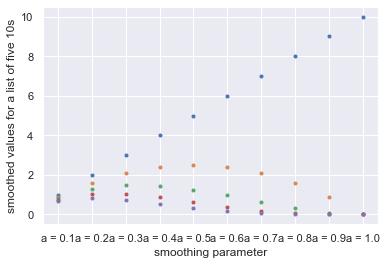

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

for i in value_df.index:
    plt.plot(value_df.loc[i,:], marker='.', linestyle='none')
plt.xlabel('smoothing parameter')
plt.ylabel('smoothed values for a list of five 10s')
plt.show()

Above: an increasing smoothing parameter boosts the most recent value and damps all other values more and more until $\alpha=1$ bases the forecast on only the last value, with all other values equal to 0.

Here's how to fit a simple exponential smoothing model to data in statsmodels:

In [ ]:
# "data" is a Pandas dataframe
result = SimpleExpSmoothing(data).fit()
forecast = result.forecast(12).rename(r'$\alpha=%s$'%result.model.params['smoothing_level'])
# plot
result.plot(marker='o', color='green', legend=True)
result.fittedvalues.plot(marker='o', color='green')

<a id='trend'></a>
### 10. Trend but not Season? Trend Models (Double Exponential Smoothing)

#### 10a. Holt Linear Trend Model

In [1]:
# imports for exponential smoothing sections
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Holt (1957) models a forecast as linear function of $h$, how many steps ahead the forecast is. The function's y-intercept is the level and the function's slope the trend value $b_t$. Whereas simple exponential smoothing provides a flat forecast, the Holt model creates a forecast with a trend: The $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value.

\begin{equation}
y_{t+h|t} = l_t + hb_t
\end{equation}

We have two smoothing parameters now, $\alpha$ for the level and $\beta$ for the trend, as used in the level and trend equations —


*level* 

The equation for the current level weights by $\alpha$ the current value and the sum of the last value's forecast parameters (level and trend):

\begin{equation}
l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})
\end{equation}

*trend*

The equation for the current trend weights by $\beta$ (1) the change in level between the last value and the current value and (2) the last value's trend:

\begin{equation}
b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}
\end{equation}

You can think of $\beta$ as change in slope over time: a high $\beta$ means that the past slope is almost entirely determining the present slope. A low $\beta$ changes slope a lot, because the last trend estimate influences current slope.

Likewise, the $\alpha$ value fades between the truth and the model's prediction of the truth: a low $\alpha$ value bases the current level almost entirely on the last value's forecast parameters, while a high $\alpha$ value bases the current level almost entirely on the current value.

In Python,

In [ ]:
fit1 = Holt(data).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False) # linear model
fcast1 = fit1.forecast(12).rename("Holt's linear trend")

fit2 = Holt(data, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False) # exponential model
fcast2 = fit2.forecast(12).rename("Exponential trend")

#### 10b. Damped Holt Models

Holt models tend to overforecast the further out they get. Gardner and McKenzie (1985) introduced formulas that dampen the trend to a flat line over time by adding a damping coefficient $\phi$ that causes the slope's growth to gradually approach zero by exponentially dampening more for each day into the future (as days into the future $h$ increases): 

\begin{equation}
y_{t+h|t} = l_t + b_t \sum_{i=1}^{h} \phi^h
\end{equation}

Moreover, the damping impacts the currenet value's level and trend by scaling the last value's measured slope (trend):

\begin{equation}
l_t = \alpha y_t + (1-\alpha)(l_{t-1} + \phi b_{t-1})
\end{equation}

\begin{equation}
b_t = \beta(l_t - l_{t-1}) + (1-\beta)\phi b_{t-1}
\end{equation}

In theory, $0 \le \phi \le 1$, but in practice $.8 \le \phi \le .98$, because the damping has too strong an effect for small values and behaves like a non-damped model too close to 1.

As days into the future $h$ increases, the forecast value converges to a value given by:

\begin{equation}
\lim_{h\to\infty} y_{t+h|h} = \frac{l_t + \phi b_t}{(1-\phi)}
\end{equation}

To fit a dampened linear Holt model in Python, specify `smoothing_level` ($\alpha$) and `smoothing_slope` ($\beta$) and let the model optimize $\phi$:

In [ ]:
fit3 = Holt(data, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Additive damped trend")

<a id='season'></a> 
### 11. Trend and Season? Holt-Winters Seasonal Models (Triple Exponential Smoothing)

Holt and his student Winters (1960) added a third smoothing equation to the forecast beyond level and trend: the seasonal component $s_t$ smoothed by a third smoothing parameter $\gamma$. The seasonal smoothing equation introduces another variable $m$ to capture the period of the seasonal component.

#### Two Sorts of Seasons

If seasonal component remains constant, use an additive model. If the seasonal component changes with respect to the level value, use a multiplicative model of the seasonal component.

#### 11a. Holt-Winters' Additive Method



We add a seasonal component to the forecast equation and to the level equation.

*the forecast*

We add a new seasonal term, $s_{t+h-m(k+1)}$, to factor in the last year's seasonal estimate on the corresponding day in the last seasonal cycle. To be sure we take the value from the last seasonal cycle, the new value $k$ in the seasonal component of the forecast is the integer part of $(h-1)/m$. Algorithmically,

In [108]:
m = 30 # 30-day seasonal period
h = 72 # we're looking 72 days into the future; the 12th day of the period
k = (h-1)//m # divide by how many periods into the future we're going
h - m*(k + 1)# look up the seasonal estimate from the corresponding day in the last period

-18

$h - m(k+1)$ is -18 here to indicate that we would take the seasonal estimate from day 12 of the data's final period (18 days into the past). So the whole forecast becomes:

\begin{equation}
y_{t+h|t} = l_t + hb_t + s_{t+h-m(k+1)}
\end{equation}

*the level component*

The level parameter $\alpha$ weights an average between the last period's estimated parameter and the last value's seasonless forecast (the sum of its level and trend).

\begin{equation}
l_t = \alpha (y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})
\end{equation}

*the trend component*

The trend stays the same as the linear model...because it's linear. $\beta$ weights an average between the difference in the level and the last value's trend.

\begin{equation}
b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}
\end{equation}

*the season component*

The season component's \gamma parameter weights an avereage between the current value's seasonal component (the current value minus the last value's level and trend predictions) and the last period's corresponding value's seasonal component:

\begin{equation}
s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1-\gamma)s_{t-m}
\end{equation}

#### 11b. Holt-Winters' Multiplicative Method

The idea of the components is more or less the same, but you multiply them instead of add them to move into the future, and you divide them instead of difference them to get back to past values:

\begin{equation}
y_{t+h|t} = (l_t + hb_t)s_{t+h-m(k+1)}
\end{equation}

\begin{equation}
l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1})
\end{equation}

\begin{equation}
b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}
\end{equation}

\begin{equation}
s_t = \gamma \frac{y_t}{l_{t-1} + b_{t-1}} + (1-\gamma)s_{t-m}
\end{equation}

#### 11c. Damped Holt-Winters

This adds damping to the change in trend as above. Damped trend with multiplicative seasonality often performs well.

In Python,

1. additive trend, additive season

1. additive trend, multiplicative season

1. additive trend, additive season with damping

1. additive trend, multiplicative season with damping

In [ ]:
fit1 = ExponentialSmoothing(saledata, seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=True)

fit2 = ExponentialSmoothing(saledata, seasonal_periods=4, trend='add', seasonal='mul').fit(use_boxcox=True)

fit3 = ExponentialSmoothing(saledata, seasonal_periods=4, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)

fit4 = ExponentialSmoothing(saledata, seasonal_periods=4, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)